In [ ]:
import csv
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

class DogDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output

## Функции для выгрузки данных в colab

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip '/content/drive/MyDrive/Archive.zip'


## Импортируем датасеты

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


with open('train_dataset', 'r') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=',')
    names, photo_paths = [], []
    for line in reader:
        names.append(line['name'])
        photo_paths.append(line['photo_path'])

train_dataset = DogDataset(photo_paths, names, transform=transform)

with open('test_dataset', 'r') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=',')
    names, photo_paths = [], []
    for line in reader:
        names.append(line['name'])
        photo_paths.append(line['photo_path'])

test_dataset = DogDataset(photo_paths, names, transform=transform)

## Создаем DataLoaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

## Инициализируем модель

In [ ]:
model = models.resnet50(weights='DEFAULT')
model = torch.nn.Sequential(*list(model.children())[:-1])

for param in model.parameters():
    param.requires_grad = False

# Разморозим только последний блок ResNet — `layer4`
for layer in list(model.children())[7:]:
    for param in layer.parameters():
        param.requires_grad = True

## Подготовка к обучению

#### Оценка точности

In [ ]:
class AverageMeters(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.cnt = 0
        self.sum = 0
        self.val = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [ ]:
def accuracy(features1, features2, target, threshold=0.5):
    with torch.no_grad():
        # Вычисляем косинусное сходство
        cos_sim = torch.nn.functional.cosine_similarity(features1, features2)

        # Применяем пороговое значение для получения предсказания (1 или -1)
        pred = torch.where(cos_sim > threshold, 1, -1)

        # Сравниваем с целевыми значениями и вычисляем точность
        correct = (pred == target).sum().item()
        accuracy = correct / target.size(0) * 100  # процент точных предсказаний
    return accuracy

#### Выбор девайса для работы

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


#### Циклы обучения и валидации

In [ ]:
def train_loop(dataloader, model, criterion, optimizer):
    losses = AverageMeters()
    accs = AverageMeters()

    # switch to train mode
    model.train()

    for _, (data, target) in enumerate(dataloader):
        data = data.to(device)

        if len(data) < 2:
            print("Skipping batch with fewer than 2 images.")
            continue

        # compute output
        features1 = model(data[0].unsqueeze(0)).view(1, -1)  # Приводим к [1, feature_dim]
        features2 = model(data[1].unsqueeze(0)).view(1, -1)
        target = torch.tensor([1 if target[0] == target[1] else -1], dtype=torch.float32).to(device)

        loss = criterion(features1, features2, target)

        # measure accurasy
        acc = accuracy(features1, features2, target)

        # record loss and accurasy
        losses.update(loss.item(), data.size(0))
        accs.update(acc, data.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return accs.avg, losses.avg

In [ ]:
def test_loop(dataloader, model, criterion):
    losses = AverageMeters()
    accs = AverageMeters()

    # switch to val mode
    model.eval()

    for _, (data, target) in enumerate(dataloader):
        data = data.to(device)

        if len(data) < 2:
            print("Skipping batch with fewer than 2 images.")
            continue

        # compute output
        features1 = model(data[0].unsqueeze(0)).view(1, -1)  # Приводим к [1, feature_dim]
        features2 = model(data[1].unsqueeze(0)).view(1, -1)
        target = torch.tensor([1 if target[0] == target[1] else -1], dtype=torch.float32).to(device)

        loss = criterion(features1, features2, target)

        # measure accurasy
        acc = accuracy(features1, features2, target)

        # record loss and accurasy
        losses.update(loss.item(), data.size(0))
        accs.update(acc, data.size(0))

    return accs.avg, losses.avg



#### Сохранение весов модели

In [ ]:
def save_checkpoint(save_path, state, epoch, tag=''):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = os.path.join(save_path, "{}checkpoint-{:06}.pth.tar".format(tag, epoch))
    torch.save(state, filename)


## Обучение

#### Инициализируем конфиги для обучения

In [ ]:
config = {
    "batch_size": 2,
    "learning_rate": 1e-3,
    "total_epochs": 40,
    "save_epoch": 5,
    "save_path": "./weights"
}

#### Инициализируем начальные состояния

In [ ]:
random_seed = 42

#### Инициализируем остальные параметры

In [ ]:
criterion = nn.CosineEmbeddingLoss()  # Косинусная потеря для похожих и непохожих изображений
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

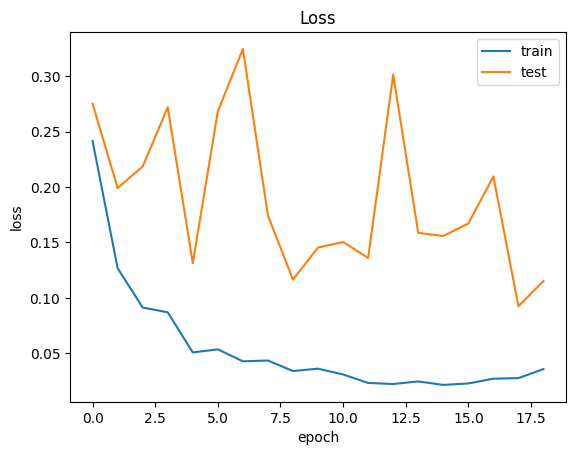

[18/40]		 LR: Train acc: 98.0	 Train loss: 0.0359	 Test acc: 92.8	 Test loss: 0.115
Skipping batch with fewer than 2 images.


In [ ]:
print("Start train")
log = {"epoch": [], "train_acc": [], "train_loss": [], "test_acc": [], "test_loss": []}

for epoch in range(config["total_epochs"]):
  train_acc, train_loss = train_loop(train_dataloader, model, criterion, optimizer)
  test_acc, test_loss = test_loop(test_dataloader, model, criterion)

  if epoch % config["save_epoch"] == 0:
      state = {
          "epoch": epoch,
          "state_dict": model.state_dict(),
          "loss": test_loss,
          "acc": test_acc,
          "optimizer": optimizer.state_dict(),
          "criterion": criterion.state_dict(),
        }
      save_checkpoint(config["save_path"], state, epoch, '')


  log["epoch"].append(epoch)
  log["train_loss"].append(train_loss)
  log["test_loss"].append(test_loss)

  clear_output(wait=True)

  plt.plot(log["epoch"], log["train_loss"], label="train")
  plt.plot(log["epoch"], log["test_loss"], label="test")
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Loss")
  plt.show()

  line = "[{}/{}]\t\t LR: Train acc: {:.3}\t Train loss: {:.3}\t Test acc: {:.3}\t Test loss: {:.3}".format(
      epoch,
      config["total_epochs"],
      train_acc,
      train_loss,
      test_acc,
      test_loss
    )

  print(line)

print("Stop train")
